In [1]:
#import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import torch
import torchvision
import torch.nn as nn
import torchmetrics
from torchvision import transforms

import torchvision.models as models
from torch.utils.data import DataLoader, Dataset,random_split
from pytorch_lightning import seed_everything, LightningModule, Trainer
from sklearn.metrics import classification_report


2021-12-12 01:03:22.722605: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


# Step 1 Read and Analyze data

In [2]:
!ls ..

Binary	code  intro.odp  multiclass


In [3]:
aug=transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
    ])

In [4]:
dataset=torchvision.datasets.ImageFolder('../Binary/',transform=aug)

In [5]:
print('length of dataset',len(dataset))
print('length of trainset',len(dataset)*0.75)
print('length of testset',len(dataset)*0.25)
int(np.floor(len(dataset)*0.75))+int(np.ceil(len(dataset)*0.25))==len(dataset)

length of dataset 746
length of trainset 559.5
length of testset 186.5


True

In [6]:
train_set, val_set =random_split(dataset,
                            [int(np.floor(len(dataset)*0.75)),int(np.ceil(len(dataset)*0.25))])
print('length of trainset',len(train_set))
print('length of testset',len(val_set))


length of trainset 559
length of testset 187


In [7]:
#data loader expect the input as tensor not as numpy or PIL
train_loader = DataLoader(dataset,shuffle=True,num_workers=0,batch_size=8)
batch=next(iter(train_loader));
print(batch[0].shape,batch[1])

torch.Size([8, 3, 224, 224]) tensor([0, 1, 0, 0, 1, 1, 0, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


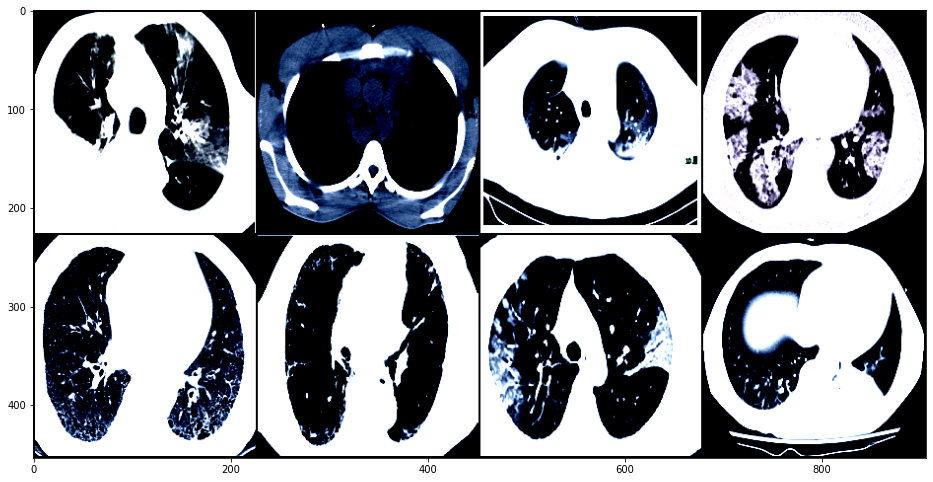

In [8]:
plt.figure(figsize=(16,16))
grid_img=torchvision.utils.make_grid(batch[0],4,2)
plt.imshow(grid_img.permute(1, 2, 0))

# 2. Test Model, Loss function and Metric

In [9]:
resnet18 = models.resnet18()
resnet18.fc=nn.Sequential(
    nn.Linear(resnet18.fc.in_features,224),
    nn.ReLU(),
    nn.Linear(224,1)
    )

In [10]:
pred=resnet18(batch[0])
print(pred.shape)
pred

torch.Size([8, 1])


tensor([[ 0.0037],
        [ 0.0610],
        [ 0.0017],
        [-0.0093],
        [ 0.0271],
        [ 0.0776],
        [ 0.1075],
        [ 0.0056]], grad_fn=<AddmmBackward>)

In [11]:
criterion=nn.BCEWithLogitsLoss()
criterion(pred.flatten(),batch[1].float())

tensor(0.6893, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)

In [12]:
accuracy = torchmetrics.Accuracy()
accuracy(pred.flatten(),batch[1])

tensor(0.5000)

# 3. Create a PL structure

In [13]:
class OurModel(LightningModule):
    def __init__(self):
        super(OurModel,self).__init__()
        # model architecute

        #parameters
        #evaluation metric
        #loss function
        #list to store loss and accurac
        
        #load data        
        
        #split data

    def forward(self,x):
        return x

    
    def configure_optimizers(self):
        return optimizer

    def train_dataloader(self):#load train 
        return data
    
    def training_step(self,batch,batch_idx):
        return whateveryouwant
        
    def training_epoch_end(self, outputs):
        pass
        
    def val_dataloader(self):
        return data

    def validation_step(self,batch,batch_idx):
        pass

    def validation_epoch_end(self, outputs):
        pass


# 4. Train and validate data via PL

In [14]:
class OurModel(LightningModule):
    def __init__(self):
        super(OurModel,self).__init__()
        # model architecute
        
        self.resnet18 = models.resnet18(pretrained=True)
        self.resnet18.fc=nn.Sequential(
            nn.Linear(self.resnet18.fc.in_features,256),
            nn.ReLU(),
            nn.Linear(256,1)
            )
        
        self.aug=transforms.Compose([
                    transforms.Resize(size=(224,224)),
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomVerticalFlip(),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225]),
                    ])
        #parameters
        self.lr=1e-4
        self.batch_size=224
        self.numworker=12
        self.acc = torchmetrics.Accuracy() #metric
        self.criterion=nn.BCEWithLogitsLoss() #loss function
        #list to store loss and accuracy
        self.trainacc,self.valacc=[],[]
        self.trainloss,self.valloss=[],[]
        
        #load data        
        self.dataset=torchvision.datasets.ImageFolder('../Binary/',transform=self.aug)
        
        #split data
        self.train_set, self.val_set =random_split(self.dataset,
                            [int(np.floor(len(dataset)*0.75)),int(np.ceil(len(dataset)*0.25))],
                                                  generator=torch.Generator().manual_seed(42))
    def forward(self,x):
        x=self.resnet18(x)
        return x

    
    def configure_optimizers(self):
        opt=torch.optim.AdamW(params=self.parameters(),lr=self.lr )
        return opt
    
    def train_dataloader(self):#load train 
        return DataLoader(self.train_set,shuffle=True,num_workers=self.numworker,batch_size=self.batch_size)

    def training_step(self,batch,batch_idx):
        image,label=batch
        pred = self(image)#pass images to model
        loss=self.criterion(pred.flatten(),label.float()) #calculate loss
        acc=self.acc(pred.flatten(),label)#calculate accuracy
        return {'loss':loss,'acc':acc}

    def training_epoch_end(self, outputs):
        #average loss and accuracy in all batches of train data
        loss=torch.stack([x["loss"] for x in outputs]).mean().detach().cpu().numpy().round(2)
        acc=torch.stack([x["acc"] for x in outputs]).mean().detach().cpu().numpy().round(2)
        self.trainacc.append(acc)
        self.trainloss.append(loss)

        
    def val_dataloader(self):
        ds=DataLoader(self.val_set,shuffle=False,num_workers=self.numworker,batch_size=self.batch_size)
        return ds

    def validation_step(self,batch,batch_idx):
        image,label=batch
        pred=self(image)
        loss=self.criterion(pred.flatten(),label.float())
        acc=self.acc(pred.flatten(),label)
        return {'loss':loss,'acc':acc}

    def validation_epoch_end(self, outputs):
        loss=torch.stack([x["loss"] for x in outputs]).mean().detach().cpu().numpy().round(2)
        acc=torch.stack([x["acc"] for x in outputs]).mean().detach().cpu().numpy().round(2)
        self.valacc.append(acc)
        self.valloss.append(loss)
        print('validation loss accuracy ',self.current_epoch,loss, acc)


In [15]:
model=OurModel()


In [16]:
seed_everything(0)
trainer = Trainer(max_epochs=15, 
                deterministic=True,
                gpus=-1,precision=16,
                accumulate_grad_batches=1,
                enable_progress_bar = False,
                num_sanity_val_steps=0,
                #limit_train_batches=20,
                #limit_val_batches=5
                )

Global seed set to 0
Using 16bit native Automatic Mixed Precision (AMP)
[W Context.cpp:69] Warning: torch.set_deterministic is in beta, and its design and  functionality may change in the future. (function operator())
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [17]:
trainer.fit(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params
------------------------------------------------
0 | resnet18  | ResNet            | 11.3 M
1 | acc       | Accuracy          | 0     
2 | criterion | BCEWithLogitsLoss | 0     
------------------------------------------------
11.3 M    Trainable params
0         Non-trainable params
11.3 M    Total params
22.616    Total estimated model params size (MB)
/home/talha/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:407: UserWarning: The number of training samples (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


validation loss accuracy  0 0.61 0.7
validation loss accuracy  1 0.53 0.72
validation loss accuracy  2 0.48 0.74
validation loss accuracy  3 0.46 0.74
validation loss accuracy  4 0.41 0.77
validation loss accuracy  5 0.37 0.79
validation loss accuracy  6 0.36 0.83
validation loss accuracy  7 0.33 0.82
validation loss accuracy  8 0.32 0.84
validation loss accuracy  9 0.28 0.89
validation loss accuracy  10 0.25 0.93
validation loss accuracy  11 0.24 0.9
validation loss accuracy  12 0.29 0.85
validation loss accuracy  13 0.38 0.85
validation loss accuracy  14 0.36 0.87


In [18]:
trainer.validate(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


validation loss accuracy  14 0.36 0.88
--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{}
--------------------------------------------------------------------------------


[{}]

Text(0.5, 1.0, 'validation and training accuracy comparison')

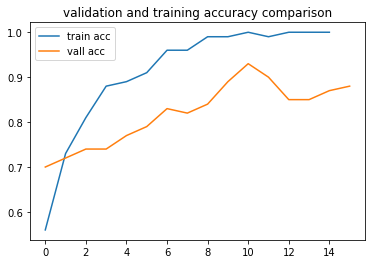

In [19]:
plt.plot(model.trainacc,label='train acc')
plt.plot(model.valacc,label='vall acc')
plt.legend()
plt.title('validation and training accuracy comparison')

Text(0.5, 1.0, 'validation and training loss comparison')

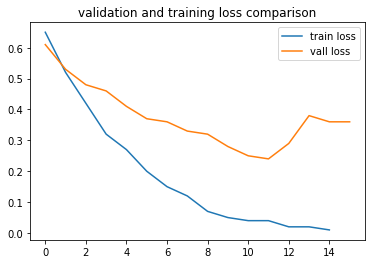

In [20]:
plt.plot(model.trainloss,label='train loss')
plt.plot(model.valloss,label='vall loss')
plt.legend()
plt.title('validation and training loss comparison')